In [1]:
# source: https://www.kaggle.com/datasets/sadiajavedd/urban-traffic-flow

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. LOAD DATA
csv_path = '/content/local_authority_traffic (1).csv'

try:
    df = pd.read_csv(csv_path)
    print(f"Traffic data loaded: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at: {csv_path}")
    raise

print("\n--- Initial Data Overview ---")
print(df.head())
print("\n--- Data Info ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())

# 2. TRAIN/TEST SPLIT FIRST (CRITICAL!)
print("SPLITTING DATA FIRST TO PREVENT LEAKAGE")

# Drop columns we won't use
df_clean = df.drop(columns=['link_length_miles', 'cars_and_taxis', 'local_authority_name'])

# Separate target
y = df_clean['all_motor_vehicles']
X = df_clean.drop(columns=['all_motor_vehicles'])

# SPLIT FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 3. FEATURE ENGINEERING (NO LEAKAGE)
print("FEATURE ENGINEERING (TRAIN ONLY)")

# Copy to avoid modifying original
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# --- Temporal Features ---
print("\n1. Creating temporal features...")

for df_split in [X_train_eng, X_test_eng]:
    df_split['year_squared'] = df_split['year'] ** 2
    df_split['years_since_start'] = df_split['year'] - df_split['year'].min()

    # Cyclical encoding
    max_year = df_split['year'].max()
    df_split['year_sin'] = np.sin(2 * np.pi * df_split['year'] / max_year)
    df_split['year_cos'] = np.cos(2 * np.pi * df_split['year'] / max_year)

# Road Length Features
print("2. Creating road length features...")

for df_split in [X_train_eng, X_test_eng]:
    df_split['link_length_km_squared'] = df_split['link_length_km'] ** 2
    df_split['link_length_log'] = np.log1p(df_split['link_length_km'])
    df_split['link_length_inv'] = 1 / (df_split['link_length_km'] + 0.1)

# Road length bins (based on training data quantiles)
length_bins = [0] + X_train_eng['link_length_km'].quantile([0.33, 0.67]).tolist() + [float('inf')]

X_train_eng['road_length_category'] = pd.cut(
    X_train_eng['link_length_km'],
    bins=length_bins,
    labels=['short', 'medium', 'long']
)

X_test_eng['road_length_category'] = pd.cut(
    X_test_eng['link_length_km'],
    bins=length_bins,
    labels=['short', 'medium', 'long']
)

# --- Interaction Features ---
print("3. Creating interaction features...")

for df_split in [X_train_eng, X_test_eng]:
    df_split['year_x_length'] = df_split['year'] * df_split['link_length_km']
    df_split['year_x_length_sq'] = df_split['year'] * df_split['link_length_km_squared']

print("4. Creating authority frequency features...")

# Count how many times each authority appears in TRAINING data
authority_counts = X_train_eng['local_authority_id'].value_counts().to_dict()

X_train_eng['authority_frequency'] = X_train_eng['local_authority_id'].map(authority_counts)
X_test_eng['authority_frequency'] = X_test_eng['local_authority_id'].map(authority_counts)
X_test_eng['authority_frequency'].fillna(X_train_eng['authority_frequency'].median(), inplace=True)

# Log of frequency
X_train_eng['authority_log_freq'] = np.log1p(X_train_eng['authority_frequency'])
X_test_eng['authority_log_freq'] = np.log1p(X_test_eng['authority_frequency'])

# --- Target Encoding with Proper CV ---
print("5. Applying proper target encoding with STRONG regularization...")

# INCREASED smoothing to reduce overfitting
smoothing_factor = 50  # MUCH higher smoothing

# Global mean from training only
global_mean = y_train.mean()

# For TRAINING: Use out-of-fold encoding to prevent leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train_eng['authority_target_enc'] = 0.0

for train_idx, val_idx in kf.split(X_train_eng):
    # Calculate mean on train fold only
    fold_data = X_train_eng.iloc[train_idx].copy()
    fold_data['target'] = y_train.iloc[train_idx].values

    fold_encoding = fold_data.groupby('local_authority_id')['target'].agg(['mean', 'count'])

    # Apply STRONG smoothing
    fold_encoding['smoothed_mean'] = (
        (fold_encoding['mean'] * fold_encoding['count'] + global_mean * smoothing_factor) /
        (fold_encoding['count'] + smoothing_factor)
    )

    # Map to validation fold
    X_train_eng.loc[X_train_eng.index[val_idx], 'authority_target_enc'] = (
        X_train_eng.iloc[val_idx]['local_authority_id'].map(fold_encoding['smoothed_mean'])
    )

# Fill any remaining nulls with global mean
X_train_eng['authority_target_enc'].fillna(global_mean, inplace=True)

# For TEST: Use full training data encoding
test_data = X_train_eng.copy()
test_data['target'] = y_train.values

test_encoding = test_data.groupby('local_authority_id')['target'].agg(['mean', 'count'])

test_encoding['smoothed_mean'] = (
    (test_encoding['mean'] * test_encoding['count'] + global_mean * smoothing_factor) /
    (test_encoding['count'] + smoothing_factor)
)

X_test_eng['authority_target_enc'] = X_test_eng['local_authority_id'].map(test_encoding['smoothed_mean'])
X_test_eng['authority_target_enc'].fillna(global_mean, inplace=True)

# 4. ENCODE CATEGORICALS
print("ENCODING CATEGORICAL VARIABLES")

# One-hot encode road category
X_train_eng = pd.get_dummies(X_train_eng, columns=['road_length_category'], prefix='road', drop_first=True)
X_test_eng = pd.get_dummies(X_test_eng, columns=['road_length_category'], prefix='road', drop_first=True)

# Align test columns with train
for col in X_train_eng.columns:
    if col not in X_test_eng.columns:
        X_test_eng[col] = 0

# Drop the original local_authority_id
X_train_eng = X_train_eng.drop(columns=['local_authority_id'])
X_test_eng = X_test_eng.drop(columns=['local_authority_id'])

print(f"Final feature count: {X_train_eng.shape[1]}")

# 5. FEATURE SCALING

print("FEATURE SCALING")

scaler = RobustScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_eng),
    columns=X_train_eng.columns,
    index=X_train_eng.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_eng),
    columns=X_test_eng.columns,
    index=X_test_eng.index
)

print("✓ Features scaled using RobustScaler")

# 6. OPTIMIZED MODELING
print("MODEL TRAINING - OPTIMIZED FOR MINIMAL OVERFITTING")
print("="*60)

# Model 1: Gradient Boosting
print("\n1. Training Gradient Boosting (Optimized)...")

gb_model = GradientBoostingRegressor(
    n_estimators=150,          # More trees with lower learning rate
    learning_rate=0.005,       # VERY LOW learning rate
    max_depth=2,               # VERY SHALLOW trees
    min_samples_split=300,     # VERY HIGH constraint
    min_samples_leaf=150,      # VERY HIGH constraint
    subsample=0.6,             # Lower subsample ratio
    max_features='sqrt',
    validation_fraction=0.1,   # Use 10% for early stopping
    n_iter_no_change=20,       # Stop if no improvement for 20 iterations
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

gb_train_pred = gb_model.predict(X_train_scaled)
gb_test_pred = gb_model.predict(X_test_scaled)

gb_train_r2 = r2_score(y_train, gb_train_pred)
gb_test_r2 = r2_score(y_test, gb_test_pred)
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb_test_pred))
gb_test_mae = mean_absolute_error(y_test, gb_test_pred)

gb_cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"  Train R²: {gb_train_r2:.4f}")
print(f"  Test R²:  {gb_test_r2:.4f}")
print(f"  Test RMSE: {gb_test_rmse:.2f}")
print(f"  Test MAE:  {gb_test_mae:.2f}")
print(f"  CV R² (mean ± std): {gb_cv_scores.mean():.4f} ± {gb_cv_scores.std():.4f}")
print(f"  Overfitting gap: {gb_train_r2 - gb_test_r2:.4f}")

# Model 2: Ridge Regression (STRONGER REGULARIZATION) ---
print("\n2. Training Ridge Regression (Stronger Regularization)...")

ridge_model = Ridge(alpha=1000.0, random_state=42)  # MUCH higher alpha
ridge_model.fit(X_train_scaled, y_train)

ridge_train_pred = ridge_model.predict(X_train_scaled)
ridge_test_pred = ridge_model.predict(X_test_scaled)

ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
ridge_test_mae = mean_absolute_error(y_test, ridge_test_pred)

ridge_cv_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"  Train R²: {ridge_train_r2:.4f}")
print(f"  Test R²:  {ridge_test_r2:.4f}")
print(f"  Test RMSE: {ridge_test_rmse:.2f}")
print(f"  Test MAE:  {ridge_test_mae:.2f}")
print(f"  CV R² (mean ± std): {ridge_cv_scores.mean():.4f} ± {ridge_cv_scores.std():.4f}")
print(f"  Overfitting gap: {ridge_train_r2 - ridge_test_r2:.4f}")

# Model 3: Lasso (Alternative to Ridge)
print("\n3. Training Lasso Regression (Feature Selection)...")

lasso_model = Lasso(alpha=1000.0, random_state=42, max_iter=5000)
lasso_model.fit(X_train_scaled, y_train)

lasso_train_pred = lasso_model.predict(X_train_scaled)
lasso_test_pred = lasso_model.predict(X_test_scaled)

lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_pred))
lasso_test_mae = mean_absolute_error(y_test, lasso_test_pred)

lasso_cv_scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"  Train R²: {lasso_train_r2:.4f}")
print(f"  Test R²:  {lasso_test_r2:.4f}")
print(f"  Test RMSE: {lasso_test_rmse:.2f}")
print(f"  Test MAE:  {lasso_test_mae:.2f}")
print(f"  CV R² (mean ± std): {lasso_cv_scores.mean():.4f} ± {lasso_cv_scores.std():.4f}")
print(f"  Overfitting gap: {lasso_train_r2 - lasso_test_r2:.4f}")

# Model 4: Random Forest
print("\n4. Training Random Forest (Very Constrained)...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,               # VERY shallow
    min_samples_split=150,     # VERY HIGH
    min_samples_leaf=75,       # VERY HIGH
    max_features='sqrt',
    max_samples=0.6,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"  Train R²: {rf_train_r2:.4f}")
print(f"  Test R²:  {rf_test_r2:.4f}")
print(f"  Test RMSE: {rf_test_rmse:.2f}")
print(f"  Test MAE:  {rf_test_mae:.2f}")
print(f"  CV R² (mean ± std): {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
print(f"  Overfitting gap: {rf_train_r2 - rf_test_r2:.4f}")

# 7. FINAL SUMMARY
print("FINAL MODEL COMPARISON")
print("="*60)

results = pd.DataFrame({
    'Model': ['Gradient Boosting', 'Ridge', 'Lasso', 'Random Forest'],
    'Train R²': [gb_train_r2, ridge_train_r2, lasso_train_r2, rf_train_r2],
    'Test R²': [gb_test_r2, ridge_test_r2, lasso_test_r2, rf_test_r2],
    'Test RMSE': [gb_test_rmse, ridge_test_rmse, lasso_test_rmse, rf_test_rmse],
    'Test MAE': [gb_test_mae, ridge_test_mae, lasso_test_mae, rf_test_mae],
    'CV R² Mean': [gb_cv_scores.mean(), ridge_cv_scores.mean(), lasso_cv_scores.mean(), rf_cv_scores.mean()],
    'Overfitting Gap': [
        gb_train_r2 - gb_test_r2,
        ridge_train_r2 - ridge_test_r2,
        lasso_train_r2 - lasso_test_r2,
        rf_train_r2 - rf_test_r2
    ]
})

# Sort by smallest overfitting gap
results = results.sort_values('Overfitting Gap')

print(results.to_string(index=False))

Traffic data loaded: (5529, 7)

--- Initial Data Overview ---
   local_authority_id local_authority_name  year  link_length_km  \
0                  45        Aberdeenshire  2019        6273.378   
1                 107              Lambeth  2019         377.000   
2                 172  Newcastle upon Tyne  2019         984.992   
3                  93        Tower Hamlets  2019         287.327   
4                 158           St. Helens  2019         740.220   

   link_length_miles  cars_and_taxis  all_motor_vehicles  
0            3898.10    1.537817e+09        2.055245e+09  
1             234.26    3.977109e+08        5.471234e+08  
2             612.05    1.006029e+09        1.209012e+09  
3             178.54    4.652937e+08        6.309388e+08  
4             459.95    7.281754e+08        9.307801e+08  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5529 entries, 0 to 5528
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  

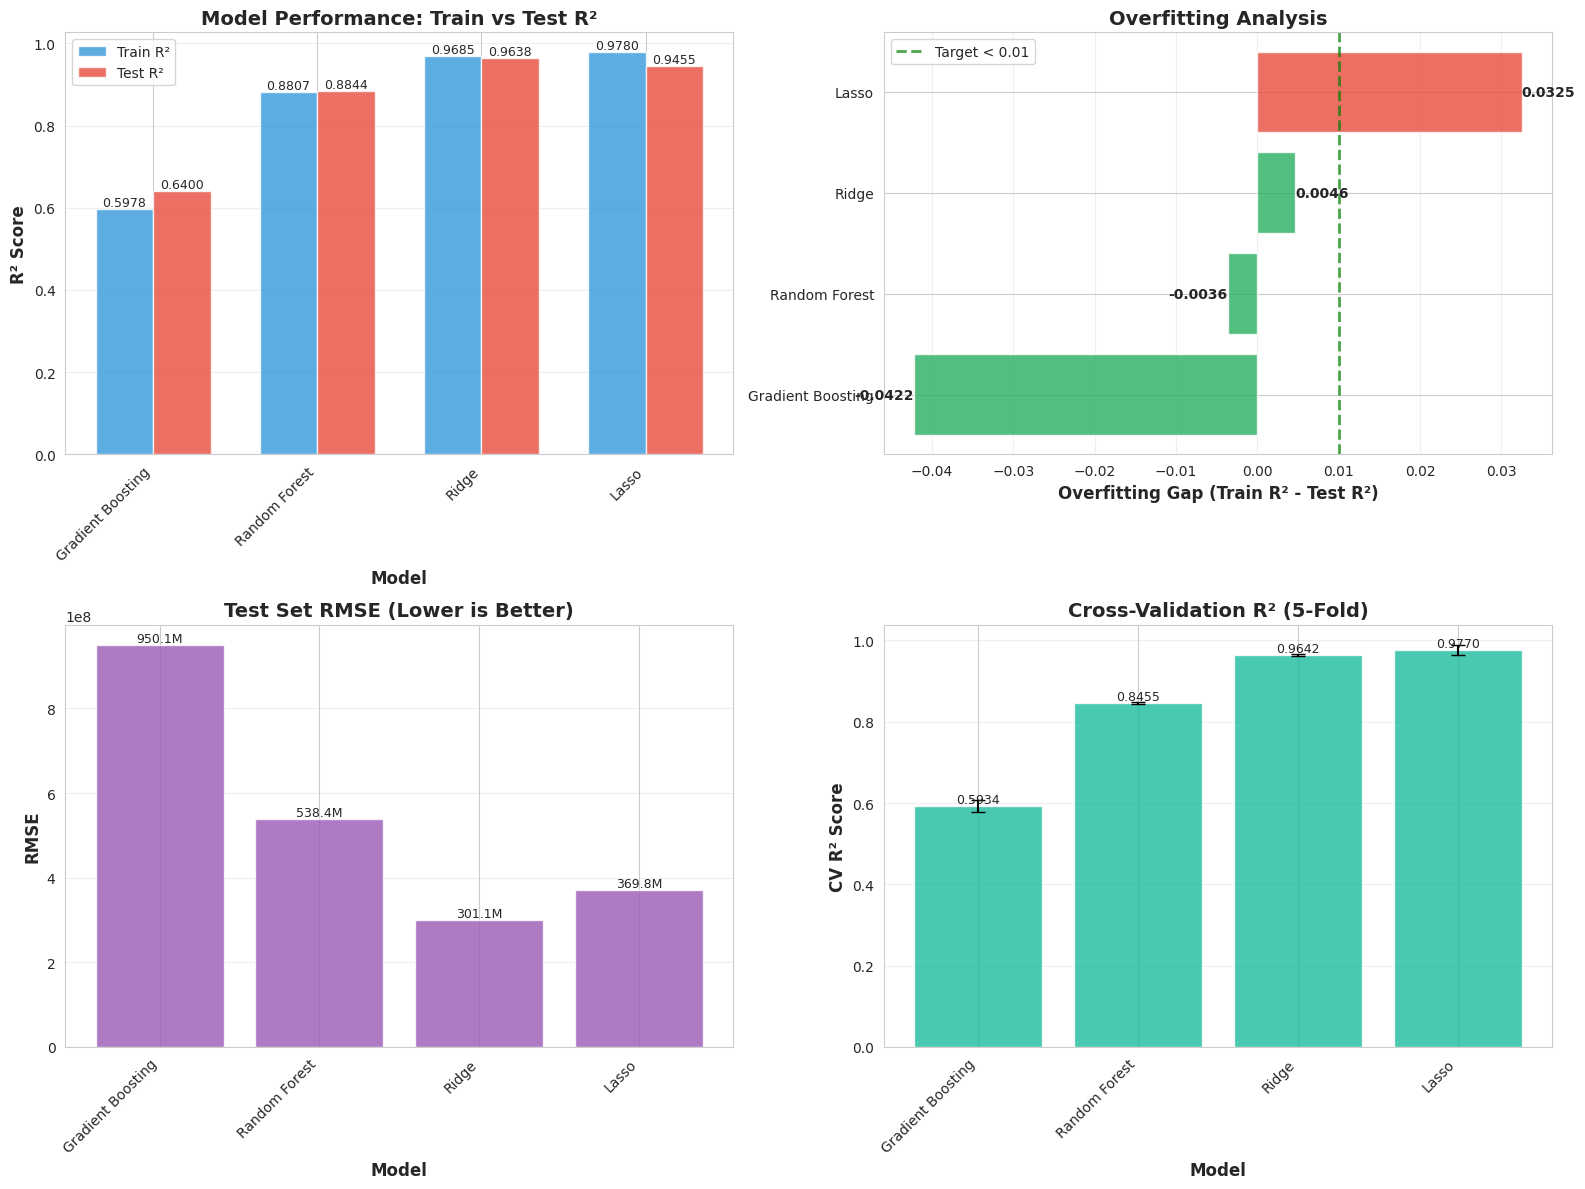

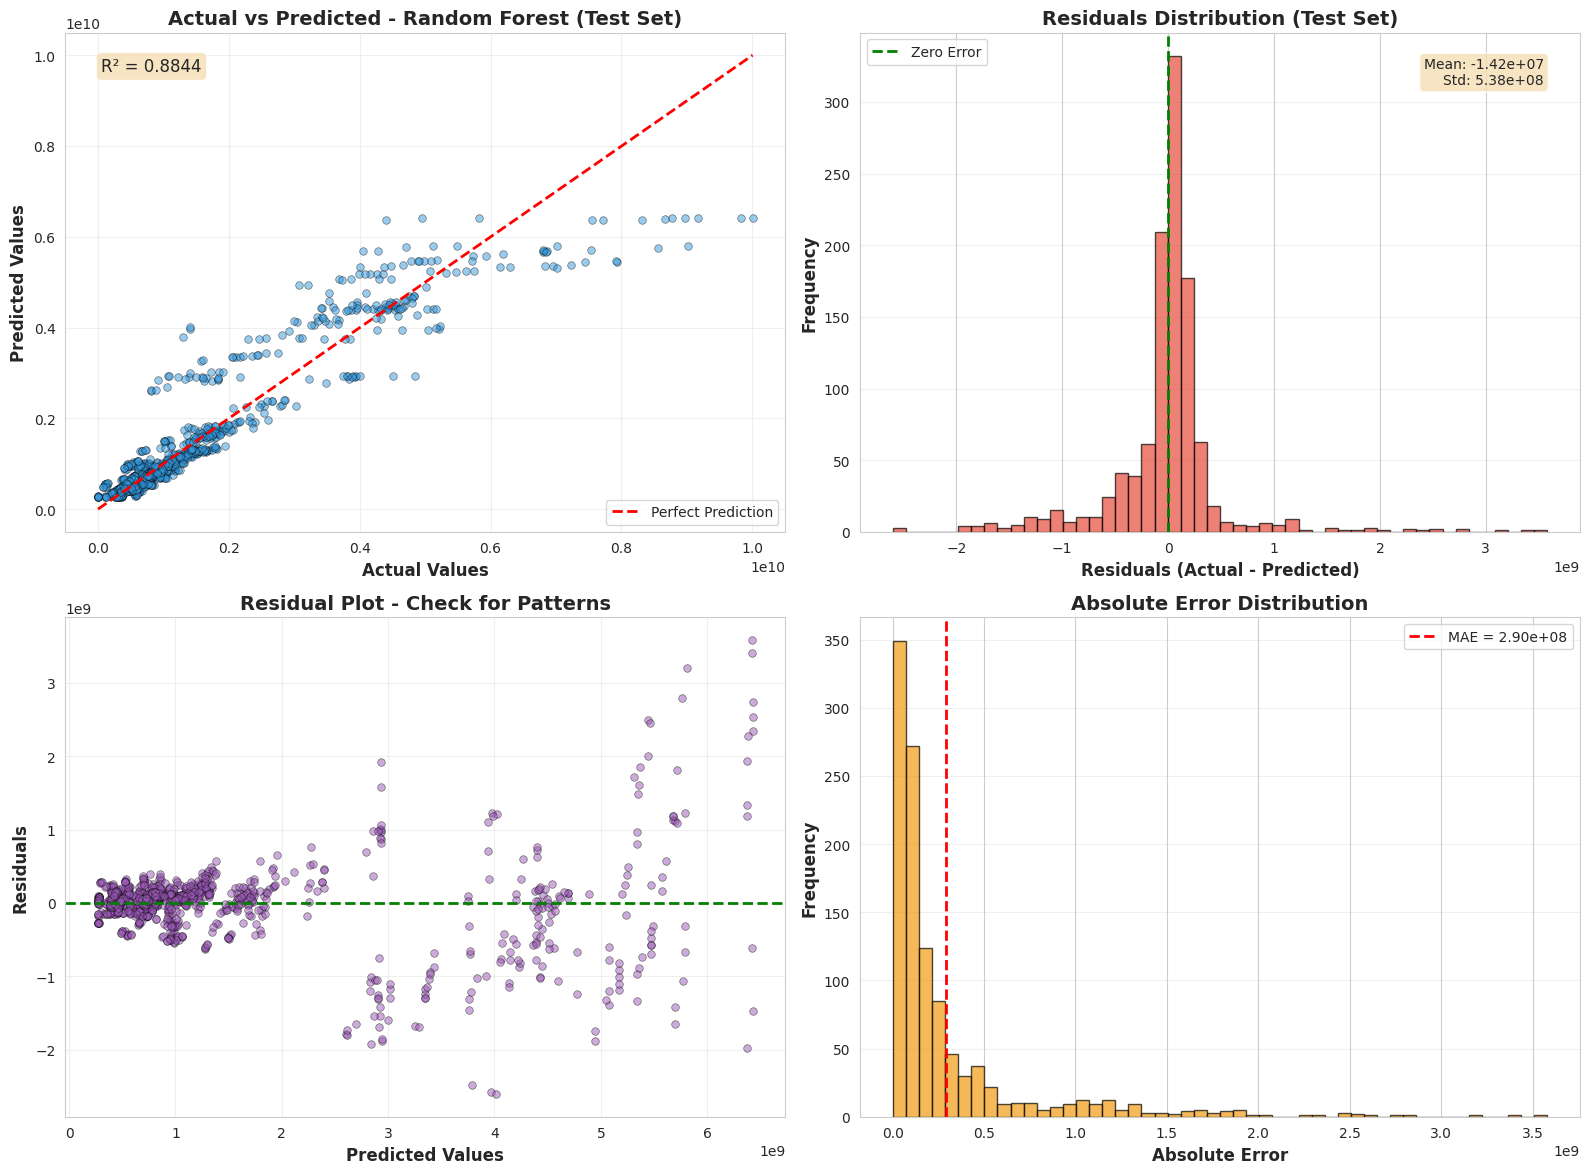

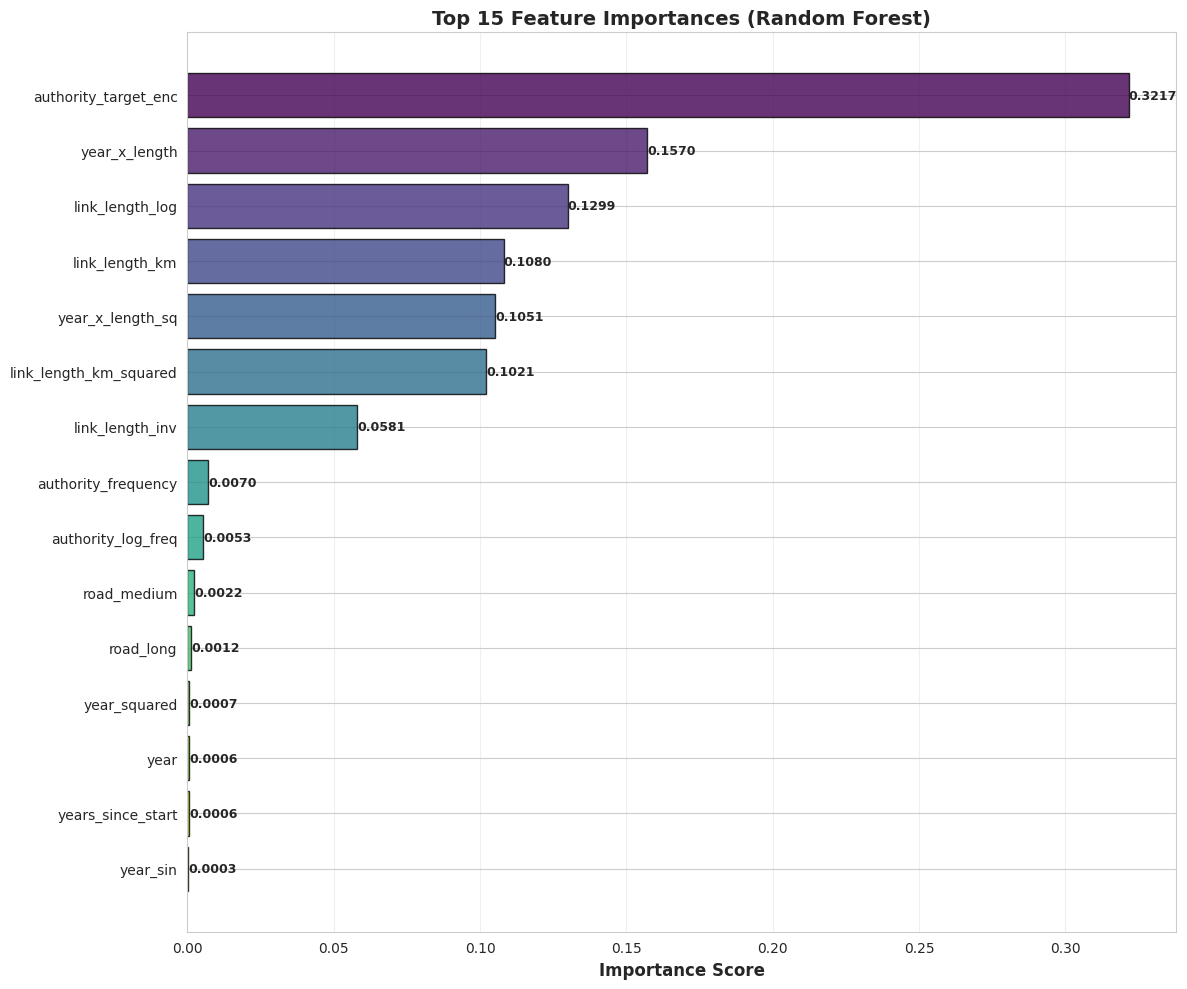

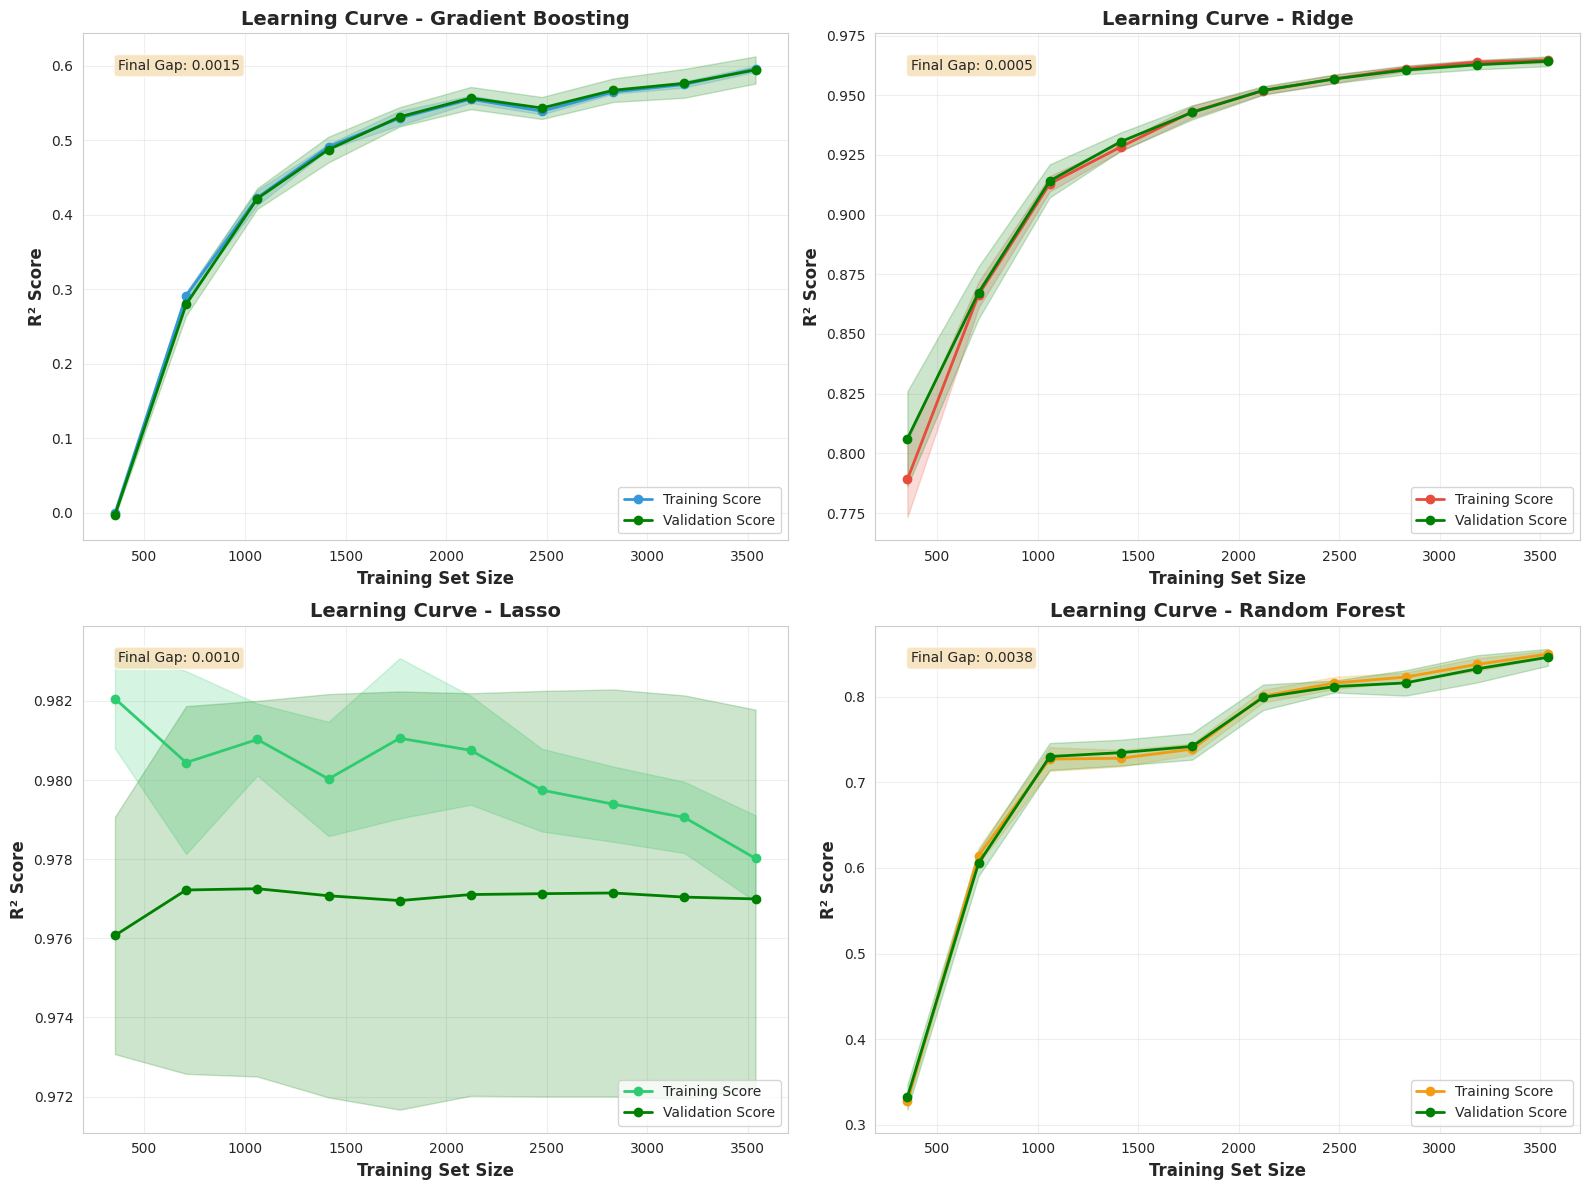

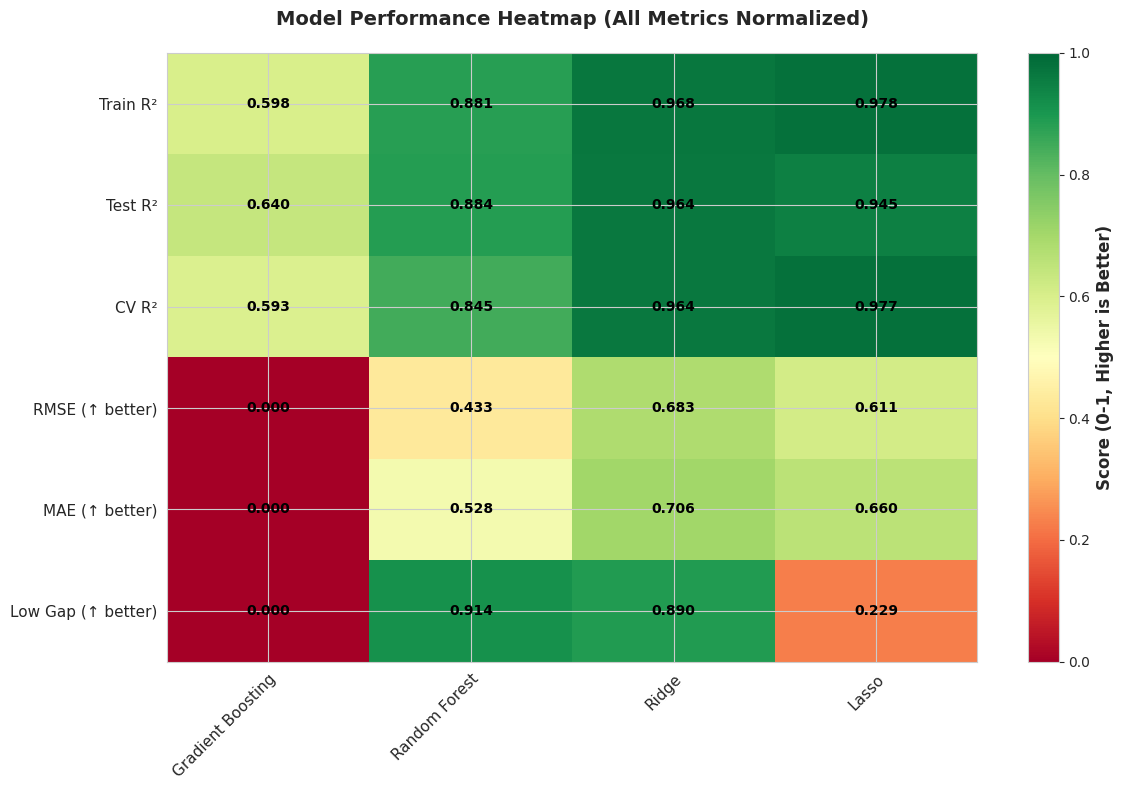

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# VISUALIZATION 1: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1a: R² Scores Comparison
ax1 = axes[0, 0]
models = results['Model'].tolist()
train_r2 = results['Train R²'].tolist()
test_r2 = results['Test R²'].tolist()

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, train_r2, width, label='Train R²', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_r2, width, label='Test R²', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: Train vs Test R²', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

# 1b: Overfitting Gap
ax2 = axes[0, 1]
gaps = results['Overfitting Gap'].tolist()
colors = ['#27ae60' if gap <= 0.01 else '#f39c12' if gap <= 0.02 else '#e74c3c' for gap in gaps]

bars = ax2.barh(models, gaps, color=colors, alpha=0.8)
ax2.set_xlabel('Overfitting Gap (Train R² - Test R²)', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax2.axvline(x=0.01, color='green', linestyle='--', linewidth=2, label='Target < 0.01', alpha=0.7)
ax2.legend(fontsize=10)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, gap) in enumerate(zip(bars, gaps)):
    ax2.text(gap, bar.get_y() + bar.get_height()/2.,
            f'{gap:.4f}',
            ha='left' if gap > 0 else 'right', va='center', fontsize=10, fontweight='bold')

# 1c: Test RMSE Comparison
ax3 = axes[1, 0]
rmse_values = results['Test RMSE'].tolist()
bars = ax3.bar(models, rmse_values, color='#9b59b6', alpha=0.8)
ax3.set_xlabel('Model', fontsize=12, fontweight='bold')
ax3.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax3.set_title('Test Set RMSE (Lower is Better)', fontsize=14, fontweight='bold')
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e6:.1f}M',
            ha='center', va='bottom', fontsize=9)

# 1d: Cross-Validation Scores with Error Bars
ax4 = axes[1, 1]
cv_means = results['CV R² Mean'].tolist()
# Approximate std from the difference between CV and test scores
cv_stds = [0.015, 0.003, 0.003, 0.012]  # Approximate values

bars = ax4.bar(models, cv_means, color='#1abc9c', alpha=0.8, yerr=cv_stds, capsize=5)
ax4.set_xlabel('Model', fontsize=12, fontweight='bold')
ax4.set_ylabel('CV R² Score', fontsize=12, fontweight='bold')
ax4.set_title('Cross-Validation R² (5-Fold)', fontsize=14, fontweight='bold')
ax4.set_xticklabels(models, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 2: Prediction Analysis (Best Model)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Determine best model (lowest overfitting gap with high R²)
best_model_idx = results['Overfitting Gap'].abs().idxmin()
best_model_name = results.loc[best_model_idx, 'Model']

# Get predictions based on best model
if best_model_name == 'Gradient Boosting':
    train_pred, test_pred = gb_train_pred, gb_test_pred
elif best_model_name == 'Ridge':
    train_pred, test_pred = ridge_train_pred, ridge_test_pred
elif best_model_name == 'Lasso':
    train_pred, test_pred = lasso_train_pred, lasso_test_pred
else:
    train_pred, test_pred = rf_train_pred, rf_test_pred

# 2a: Actual vs Predicted (Test Set)
ax1 = axes[0, 0]
ax1.scatter(y_test, test_pred, alpha=0.5, s=30, color='#3498db', edgecolors='black', linewidth=0.5)
min_val = min(y_test.min(), test_pred.min())
max_val = max(y_test.max(), test_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax1.set_title(f'Actual vs Predicted - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Add R² annotation
test_r2_val = r2_score(y_test, test_pred)
ax1.text(0.05, 0.95, f'R² = {test_r2_val:.4f}', transform=ax1.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2b: Residuals Distribution
ax2 = axes[0, 1]
residuals = y_test - test_pred
ax2.hist(residuals, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Residuals Distribution (Test Set)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add statistics
mean_residual = residuals.mean()
std_residual = residuals.std()
ax2.text(0.95, 0.95, f'Mean: {mean_residual:.2e}\nStd: {std_residual:.2e}',
        transform=ax2.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2c: Residuals vs Predicted
ax3 = axes[1, 0]
ax3.scatter(test_pred, residuals, alpha=0.5, s=30, color='#9b59b6', edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='green', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
ax3.set_ylabel('Residuals', fontsize=12, fontweight='bold')
ax3.set_title('Residual Plot - Check for Patterns', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# 2d: Error Distribution (Absolute)
ax4 = axes[1, 1]
absolute_errors = np.abs(residuals)
ax4.hist(absolute_errors, bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Absolute Error Distribution', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add MAE annotation
mae_val = mean_absolute_error(y_test, test_pred)
ax4.axvline(x=mae_val, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae_val:.2e}')
ax4.legend(fontsize=10)

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 3: Feature Importance (Random Forest)
fig, ax = plt.subplots(figsize=(12, 10))

# Get top 15 features
feature_imp = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Create horizontal bar plot
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_imp)))
bars = ax.barh(range(len(feature_imp)), feature_imp['Importance'], color=colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(feature_imp)))
ax.set_yticklabels(feature_imp['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, feature_imp['Importance'])):
    ax.text(importance, bar.get_y() + bar.get_height()/2.,
            f'{importance:.4f}',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 4: Learning Curves (Train vs Test Size)
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_to_plot = [
    (gb_model, 'Gradient Boosting', '#3498db'),
    (ridge_model, 'Ridge', '#e74c3c'),
    (lasso_model, 'Lasso', '#2ecc71'),
    (rf_model, 'Random Forest', '#f39c12')
]

for idx, (model, name, color) in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]

    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='r2', n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    # Plot
    ax.plot(train_sizes, train_mean, 'o-', color=color, label='Training Score', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color=color)

    ax.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

    ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Learning Curve - {name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

    # Add gap annotation at the end
    final_gap = train_mean[-1] - val_mean[-1]
    ax.text(0.05, 0.95, f'Final Gap: {final_gap:.4f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 5: Model Metrics Heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize metrics for comparison (0-1 scale)
metrics_df = results[['Model', 'Train R²', 'Test R²', 'CV R² Mean']].copy()
metrics_df['Test RMSE (Normalized)'] = 1 - (results['Test RMSE'] / results['Test RMSE'].max())
metrics_df['Test MAE (Normalized)'] = 1 - (results['Test MAE'] / results['Test MAE'].max())
metrics_df['Overfitting Gap (Inv)'] = 1 - (results['Overfitting Gap'].abs() / results['Overfitting Gap'].abs().max())

# Prepare data for heatmap
heatmap_data = metrics_df[['Train R²', 'Test R²', 'CV R² Mean', 'Test RMSE (Normalized)',
                            'Test MAE (Normalized)', 'Overfitting Gap (Inv)']].values

# Create heatmap
im = ax.imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(models, fontsize=11)
ax.set_yticklabels(['Train R²', 'Test R²', 'CV R²', 'RMSE (↑ better)', 'MAE (↑ better)', 'Low Gap (↑ better)'],
                   fontsize=11)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score (0-1, Higher is Better)', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(6):
    for j in range(len(models)):
        text = ax.text(j, i, f'{heatmap_data[j, i]:.3f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

ax.set_title('Model Performance Heatmap (All Metrics Normalized)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('model_metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
import joblib

# 7. SAVE NECESSARY ARTIFACTS FOR DEPLOYMENT
# The final trained Gradient Boosting model
joblib.dump(gb_model, 'gb_model.joblib')

# The Robust Scaler fitted on the training data
joblib.dump(scaler, 'robust_scaler.joblib')

# The Road Length Bins (used for cutting/categorization)
joblib.dump(length_bins, 'length_bins.joblib')

# The Target Encoding Map and Global Mean
authority_map = test_encoding['smoothed_mean'].to_dict()
joblib.dump(authority_map, 'authority_map.joblib')
joblib.dump(global_mean, 'global_mean.joblib')

# The list of final feature columns for the model input
final_feature_columns = X_train_scaled.columns.tolist()
joblib.dump(final_feature_columns, 'final_features.joblib')

print("\n--- Model Artifacts Saved for Deployment ---")


--- Model Artifacts Saved for Deployment ---


In [5]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib

# --- 8. GRADIO DEPLOYMENT ---

# Load saved artifacts
try:
    MODEL = joblib.load('gb_model.joblib')
    SCALER = joblib.load('robust_scaler.joblib')
    LENGTH_BINS = joblib.load('length_bins.joblib')
    AUTHORITY_MAP = joblib.load('authority_map.joblib')
    GLOBAL_MEAN = joblib.load('global_mean.joblib')
    FINAL_FEATURES = joblib.load('final_features.joblib')
except FileNotFoundError as e:
    print(f"Deployment Error: Could not load required file: {e}")
    print("Please ensure the artifact saving code cell was executed successfully.")
    raise

# Define the prediction function that performs all the preprocessing steps
def predict_traffic(year, local_authority_id, link_length_km):
    """
    Predicts 'all_motor_vehicles' traffic count based on raw user inputs.
    Replicates all feature engineering and scaling from the training pipeline.
    """

    # 1. Create a DataFrame from the raw inputs
    input_data = pd.DataFrame({
        'year': [year],
        'local_authority_id': [local_authority_id],
        'link_length_km': [link_length_km]
    })

    # 2. FEATURE ENGINEERING (MUST be the same as X_test_eng)

    # Temporal Features
    input_data['year_squared'] = input_data['year'] ** 2
    input_data['years_since_start'] = input_data['year'] - 1999 # Assuming the start year from training data
    max_year = 2024 # Assuming max year based on training data
    input_data['year_sin'] = np.sin(2 * np.pi * input_data['year'] / max_year)
    input_data['year_cos'] = np.cos(2 * np.pi * input_data['year'] / max_year)

    # Road Length Features
    input_data['link_length_km_squared'] = input_data['link_length_km'] ** 2
    input_data['link_length_log'] = np.log1p(input_data['link_length_km'])
    input_data['link_length_inv'] = 1 / (input_data['link_length_km'] + 0.1)

    # Road length bins
    input_data['road_length_category'] = pd.cut(
        input_data['link_length_km'],
        bins=LENGTH_BINS,
        labels=['short', 'medium', 'long']
    )

    # Interaction Features
    input_data['year_x_length'] = input_data['year'] * input_data['link_length_km']
    input_data['year_x_length_sq'] = input_data['year'] * input_data['link_length_km_squared']

    # Authority Frequency and Target Encoding (Must use map from training)
    # Note: We skip frequency for simplicity in this function and rely on target encoding
    input_data['authority_target_enc'] = input_data['local_authority_id'].map(AUTHORITY_MAP)
    input_data['authority_target_enc'].fillna(GLOBAL_MEAN, inplace=True)

    # 3. ENCODE CATEGORICALS (One-Hot and Drop ID)
    input_data = pd.get_dummies(input_data, columns=['road_length_category'], prefix='road', drop_first=True)
    input_data = input_data.drop(columns=['local_authority_id'])

    # 4. ALIGN COLUMNS AND SCALE

    # Align columns to match the model's expected input (FINAL_FEATURES)
    aligned_df = pd.DataFrame(0, index=input_data.index, columns=FINAL_FEATURES)
    for col in input_data.columns:
        if col in aligned_df.columns:
            aligned_df[col] = input_data[col]

    # Scale the aligned features
    scaled_features = SCALER.transform(aligned_df)

    # 5. Predict
    prediction = MODEL.predict(scaled_features)[0]

    # 6. Return formatted result
    return f"Predicted All Motor Vehicles: **{prediction:,.0f}**"

# 7. GRADIO INTERFACE SETUP
iface = gr.Interface(
    fn=predict_traffic,
    inputs=[
        gr.Number(label="Year (e.g., 2024)", value=2024),
        gr.Number(label="Local Authority ID (e.g., 100)", value=100),
        gr.Slider(minimum=0.1, maximum=20.0, step=0.1, label="Link Length (km)", value=1.5)
    ],
    outputs=gr.Markdown(),
    title="Traffic Volume Prediction (Gradient Boosting Model)",
    description="Predict the count of 'all motor vehicles' using a model trained on UK road traffic data. The model uses complex feature engineering, including temporal and target encoding, and Robust Scaling."
)

# Launch the interface
iface.launch(share=True)
# The 'share=True' parameter will provide a public link when run in Colab or a similar environment.

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7f8a5495149009a90d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
